<a href="https://colab.research.google.com/github/sag005/CSE291-Text-Mining/blob/main/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from pandas.core.dtypes.dtypes import dtypes
import pandas as pd
from collections import defaultdict
df = pd.read_csv('nyt.csv', dtype = defaultdict(str), engine='python')

print(len(df))

df.head(10)

11519


,text,label
0,(reuters) - carlos tevez sealed his move to ju...,sports
1,if professional pride and strong defiance can ...,sports
2,"palermo, sicily — roberta vinci beat top-seede...",sports
3,spain's big two soccer teams face a pair of it...,sports
4,the argentine soccer club san lorenzo complete...,sports
5,bryce petty had to wait behind a heisman troph...,sports
6,paris — wild card gael monfils confirmed there...,sports
7,"crans-sur-sierre, switzerland — anirban lahiri...",sports
8,"miami — the first order of business, after the...",sports
9,a year's absence from the united states open h...,sports


In [8]:
import numpy as np
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [10]:
!pip install gensim -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
import pandas as pd
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import multiprocessing
from collections import defaultdict

In [59]:
def clean_data(text):
    text = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', text)
    text = re.sub(r'[\\/×\^\]\[÷]', '', text)
    return text
def change_lower(text):
    text = text.lower()
    return text

stopwords_list = stopwords.words("english")
vocab = defaultdict(int)
def remover(text):
    text_tokens = text.split(" ")
    final_list = [word for word in text_tokens if not word in stopwords_list]
    vocab[word] += 1
    return final_list


In [60]:
df["tokens"] = df["text"].apply(change_lower).apply(clean_data).apply(remover)

In [164]:
X_train = []
def doc2vec(text):
  not_in_vocab = 0
  doc = None
  for word in text:
    try:
      embed = embeddings_index[word]
    except:
      not_in_vocab = not_in_vocab + 1
    else:
      if doc is not None:
        doc = np.vstack((doc, embed))
      else:
        doc = embed
  # print(doc.shape)
  return np.mean(doc, axis=0)

In [165]:
df["word2vec"] = df["tokens"].apply(doc2vec)

In [168]:
X  = np.array(df['word2vec'].tolist())

In [173]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
label_list = df.label.to_numpy().reshape(-1,1)
y_fit = label_encoder.fit(label_list)
y = y_fit.transform(label_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11111, random_state=42)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [174]:
X_train.shape

(9215, 100)

In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9713541666666666
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       144
           1       0.88      0.93      0.91       134
           2       1.00      0.98      0.99       874

    accuracy                           0.97      1152
   macro avg       0.93      0.95      0.94      1152
weighted avg       0.97      0.97      0.97      1152



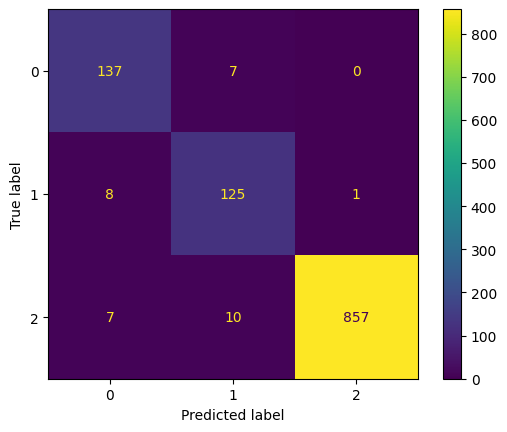

In [179]:
clf_balanced = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
print(clf_balanced.score(X_val, y_val))

cm = metrics.confusion_matrix(y_val, clf_balanced.predict(X_val))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(metrics.classification_report(y_val, clf_balanced.predict(X_val)))

0.9782986111111112
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       159
           1       0.91      0.94      0.92       162
           2       1.00      1.00      1.00       831

    accuracy                           0.98      1152
   macro avg       0.95      0.95      0.95      1152
weighted avg       0.98      0.98      0.98      1152



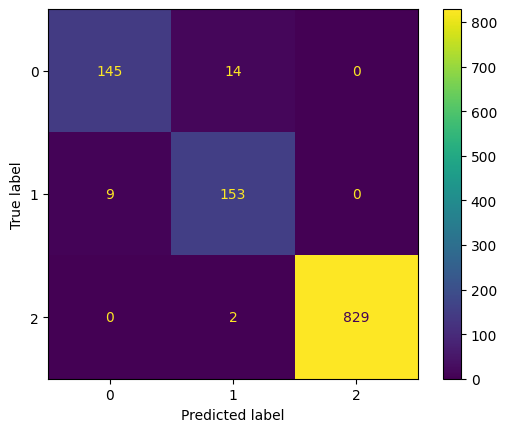

In [180]:
print(clf_balanced.score(X_test, y_test))
cm = metrics.confusion_matrix(y_test, clf_balanced.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(metrics.classification_report(y_test, clf_balanced.predict(X_test)))
     

### Q2 Part 2

In [183]:
df_ag = pd.read_csv('ag.csv', dtype = defaultdict(str), engine='python')

print(len(df_ag))

df_ag["tokens"] = df_ag["text"].apply(change_lower).apply(clean_data).apply(remover)

90000


In [184]:
sentences = df_ag['tokens'].tolist()

In [189]:
import multiprocessing
from gensim.models import Word2Vec

def train_w2v(sentences):
    cores = multiprocessing.cpu_count()
    w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
    
    w2v_model.build_vocab(sentences, progress_per=10000)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
    return w2v_model

In [191]:
model = train_w2v(sentences)

In [193]:
def doc2vec_AG(text):
  not_in_vocab = 0
  doc = None
  for word in text:
    try:
      embed = model.wv[word]
    except:
      not_in_vocab = not_in_vocab + 1
    else:
      if doc is not None:
        doc = np.vstack((doc, embed))
      else:
        doc = embed
  # print(doc.shape)
  return np.mean(doc, axis=0)

In [194]:
df["word2vec-AG"] = df["tokens"].apply(doc2vec_AG)

In [195]:
X  = np.array(df['word2vec-AG'].tolist())

In [196]:
label_encoder = LabelEncoder()
label_list = df.label.to_numpy().reshape(-1,1)
y_fit = label_encoder.fit(label_list)
y = y_fit.transform(label_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11111, random_state=42)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0.9739583333333334
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       144
           1       0.89      0.95      0.92       134
           2       1.00      0.98      0.99       874

    accuracy                           0.97      1152
   macro avg       0.93      0.96      0.95      1152
weighted avg       0.98      0.97      0.97      1152



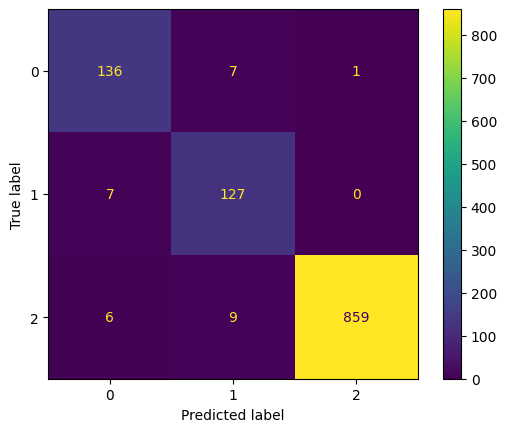

In [197]:
w2v_clf_balanced = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
print(w2v_clf_balanced.score(X_val, y_val))

cm = metrics.confusion_matrix(y_val, w2v_clf_balanced.predict(X_val))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(metrics.classification_report(y_val, w2v_clf_balanced.predict(X_val)))

0.9730902777777778
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       159
           1       0.89      0.93      0.91       162
           2       1.00      1.00      1.00       831

    accuracy                           0.97      1152
   macro avg       0.94      0.94      0.94      1152
weighted avg       0.97      0.97      0.97      1152



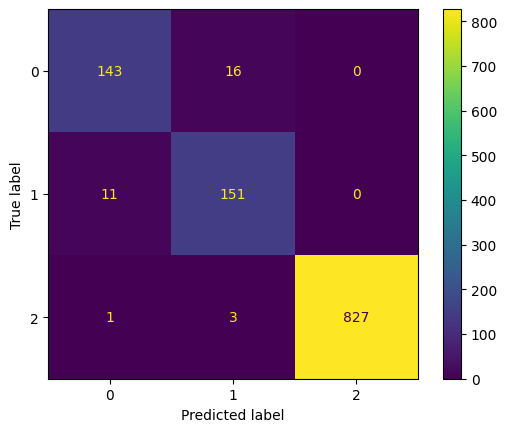

In [198]:
print(w2v_clf_balanced.score(X_test, y_test))
cm = metrics.confusion_matrix(y_test, w2v_clf_balanced.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(metrics.classification_report(y_test, w2v_clf_balanced.predict(X_test)))

### Q2 Part 3

In [199]:
sentences = df['tokens'].tolist()

In [200]:
label_encoder = LabelEncoder()
label_list = df.label.to_numpy().reshape(-1,1)
y_fit = label_encoder.fit(label_list)
y = y_fit.transform(label_list)
X_train, X_test, y_train, y_test = train_test_split(sentences, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11111, random_state=42)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [203]:
model2 = train_w2v(X_train)

In [204]:
def doc2vec_NYT(text):
  not_in_vocab = 0
  doc = None
  for word in text:
    try:
      embed = model2.wv[word]
    except:
      not_in_vocab = not_in_vocab + 1
    else:
      if doc is not None:
        doc = np.vstack((doc, embed))
      else:
        doc = embed
  # print(doc.shape)
  return np.mean(doc, axis=0)

In [205]:
X_train = pd.Series(X_train).apply(doc2vec_NYT)
X_val = pd.Series(X_val).apply(doc2vec_NYT)
X_test = pd.Series(X_test).apply(doc2vec_NYT)

In [208]:
X_train = np.array(X_train.tolist())

In [209]:
X_val = np.array(X_val.tolist())
X_test = np.array(X_test.tolist())

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9782986111111112
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       144
           1       0.91      0.94      0.93       134
           2       1.00      0.99      0.99       874

    accuracy                           0.98      1152
   macro avg       0.95      0.96      0.95      1152
weighted avg       0.98      0.98      0.98      1152



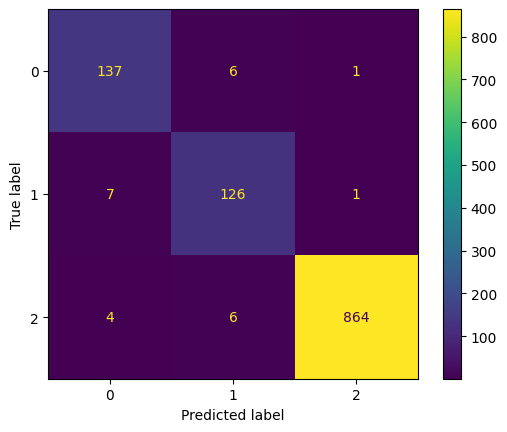

In [210]:
w2v_clf_balanced = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
print(w2v_clf_balanced.score(X_val, y_val))

cm = metrics.confusion_matrix(y_val, w2v_clf_balanced.predict(X_val))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(metrics.classification_report(y_val, w2v_clf_balanced.predict(X_val)))

0.9791666666666666
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       159
           1       0.92      0.94      0.93       162
           2       1.00      1.00      1.00       831

    accuracy                           0.98      1152
   macro avg       0.95      0.96      0.95      1152
weighted avg       0.98      0.98      0.98      1152



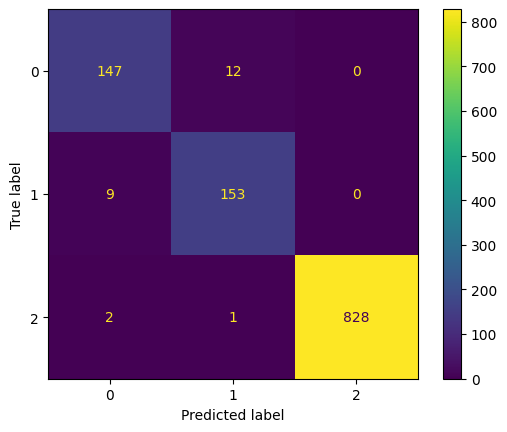

In [211]:
print(w2v_clf_balanced.score(X_test, y_test))
cm = metrics.confusion_matrix(y_test, w2v_clf_balanced.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(metrics.classification_report(y_test, w2v_clf_balanced.predict(X_test)))

In [213]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 22.2 MB/s eta 0:00:00


In [252]:
from transformers import AutoTokenizer
from datasets import load_dataset, DatasetDict, ClassLabel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
labels = ClassLabel(num_classes=3, names=['business', 'politics', 'sports'])
def tokenize_function(examples):
    t = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)
    t['label'] = labels.str2int(examples['label'])
    return t

In [248]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [253]:
dataset = load_dataset("csv", data_files = "nyt.csv")
ds = dataset["train"].train_test_split(test_size=.1, seed=42)
dst = ds["train"].train_test_split(test_size=.11111, seed=42)
train_test_valid_dataset = DatasetDict({
    'train': dst['train'],
    'test': dst['test'],
    'valid': ds['test']})

  0%|          | 0/1 [00:00<?, ?it/s]

In [254]:
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9215
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1152
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1152
    })
})

In [255]:
tokenized_datasets = train_test_valid_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/9215 [00:00<?, ? examples/s]

Map:   0%|          | 0/1152 [00:00<?, ? examples/s]

Map:   0%|          | 0/1152 [00:00<?, ? examples/s]

In [256]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [257]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [239]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.9 MB/s eta 0:00:00


In [258]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [259]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [260]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=3, load_best_model_at_end= True, save_strategy="epoch")

In [261]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    compute_metrics=compute_metrics,
)

In [264]:
import torch.cuda
import torch
torch.cuda.is_available()

False

In [262]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored